In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import keras
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# You can specify the GPU to use here by giving an integer.
# A value of "-1" means to use the CPU. 
# A CPU is okay to use for testing, but reaallly slow for training.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

Using TensorFlow backend.


In [2]:
# Turns out that the version of pillow (PIL) you have installed
# may be very important due to differences in how images are resized. 
# There seems to be different behaviour in PIL 6.0 vs 7.0.
# If a model was trained on PIL 7, and you are running PIL 6, 
# there may be an issue.
import PIL
PIL.__version__

'7.1.0'

<h2>Helper functions</h2>

In [3]:
def mean_subtraction(x, args=None):
    # subtract means then normalize to between -2 and 2 (equivalent to old Keras preprocessing function)
    mean_r, mean_g, mean_b = args
    x -= [mean_r, mean_g, mean_b]
    x /= 127.5
    return x

In [4]:
def load_model_spec(dir_model):
    model_spec_filename = os.path.join(dir_model, 'model_spec.json') 
    
    with open(model_spec_filename) as f:
        model_spec = json.load(f)
        
    return model_spec

In [5]:
def load_model(dir_model):
    model_filename = os.path.join(dir_model, 'model_max_acc_1_gpu.hdf5')
    model = keras.models.load_model(model_filename)
    return model

In [6]:
def load_preprocess_image(img_path, target_size, crop_coords=None, pre_func=None, pre_args=None):
    x = plt.imread(img_path)
    if crop_coords is not None:
        x = x[crop_coords[1]:crop_coords[1]+crop_coords[2], crop_coords[0]:crop_coords[0]+crop_coords[3],:]
    
    x = Image.fromarray(x)
    x = x.resize((target_size[0], target_size[1]))
    x = keras.preprocessing.image.img_to_array(x)
    
    if pre_func is not None:
        x = pre_func(x, pre_args)
        
    return x

In [7]:
def json_to_mm(mm_json):
    index_to_diagnosis = {}
    for record in mm_json:
        key = record['class_index']
        if key in index_to_diagnosis:
            raise ValueError("Error: multiple keys found")
        else:
            index_to_diagnosis[key] = record['diagnosis_name']
        
    return index_to_diagnosis

In [8]:
def preds_from_probs(probs):
    probs = np.squeeze(np.asarray(probs))
    avg_probs = np.mean(np.asarray(probs), axis=0)
    preds = avg_probs.argsort()[::-1]
    return preds, avg_probs

In [9]:
def get_title_pred_str(sorted_preds, probs, index_to_diagnosis, max_k):
    top_k = np.arange(0,max_k)
    title_str = "id: {}\n".format(img_id)
    for k in top_k:
        pred_label = index_to_diagnosis[sorted_preds[k]]
        pred_prob = probs[sorted_preds[k]]
        title_str += "top-{}={} {:.2f} \n".format(k+1, pred_label[:15], pred_prob)
        
    return title_str

<h2>Specify the model and data</h2>

In [10]:
# Map each node output of the CNN to a diagnosis name.
modelmap_filename = '/data/models/133_way_v2_april_2020/modelmap.json'
with open(modelmap_filename) as f:
    mm_json = json.load(f)
    
index_to_diagnosis = json_to_mm(mm_json)

In [11]:
# Root directory where the models are stored.
dir_root = '/data/models/133_way_v2_april_2020/ensemble_best_performing'

# Specify the model directories to use.
dir_models = []
dir_models.append(
    os.path.join(
        dir_root, 
        '2020_03_31_15-16-23_Anirudh_macroscopic_133_march2920_xception_no_val_aug_baseline/train/xception_60_epochs/iter_0/'
    )
)

dir_models.append(
    os.path.join(
        dir_root, 
        '2020_03_26_12-10-44_Anirudh_macroscopic_133_march2620_inception_v3_baseline/train/inception_v3_60_epochs/iter_0/'
    )
)

dir_models.append(
    os.path.join(
        dir_root,
        '2020_03_27_14-47-12_Anirudh_macroscopic_133_march2720_inception_resnet_v2_baseline/train/inception_resnet_v2_60_epochs/iter_0/'
    )
)

In [12]:
# Root directory to the images.
dir_images = '/data/lab/images/files'

In [13]:
# You will have to download this.
# For this example, download the manifest from here:
# https://lab.aip.com/snapshots/derm-100-test-update-13-reviews
# and re-named it to the below name.
data_manifest_filename = 'manifest_app-incoming-100.json'
with open(data_manifest_filename) as f:
    data_manifest = json.load(f)

In [14]:
# Convert to a dictionary where the keys are the image ID and the values are the JSON record.
all_id_to_record = {}
for record in data_manifest:
    key = record['id']
    if key in all_id_to_record:
        raise ValueError("Duplicate keys")
    else:
        all_id_to_record[key] = record

In [15]:
# Can specify a subset of the images to get predictions for.
# This will be faster.
#target_key = 6840955
#id_to_record = {}
#id_to_record[target_key] = all_id_to_record[target_key]

# Otherwise use all the images.
id_to_record = all_id_to_record

<h2>Inference</h2>

In [16]:
# Store the predicted probabilities for cropped and un-cropped images. 
all_probs_crop = {}
all_probs_uncrop = {}

# Loop over all the different models.
for dir_model in dir_models:
    print(dir_model)
    
    # Load model and model preprocessing functions.
    model_spec = load_model_spec(dir_model)
    target_size = model_spec['target_size']
    pre_args = model_spec['preprocess_args']
    assert model_spec['preprocess_func'] == 'mean_subtraction', "This code only supports mean subtraction at this time."
    model = load_model(dir_model)
    
    # Loop over images.
    for img_id in id_to_record:
        
        sample = id_to_record[img_id]
        crop = sample['crop']
        img_filename = sample['storage_key']
        img_path = os.path.join(dir_images, img_filename)
        
        # Preproces and crop the image.
        pre_img = load_preprocess_image(img_path, target_size, crop_coords=crop, pre_func=mean_subtraction, pre_args=pre_args)
        
        # Forward pass through the model.
        probs = model.predict(pre_img[np.newaxis,:])
        
        # Store the probabilities for the given model.
        all_probs_crop.setdefault(img_id,[]).append(probs)
        
        # NOT CROPPED
        pre_img = load_preprocess_image(
            img_path, target_size, crop_coords=None, # NOTE THIS IS NOT CROPPED. 
            pre_func=mean_subtraction, pre_args=pre_args
        )
        
        probs = model.predict(pre_img[np.newaxis,:])
        all_probs_uncrop.setdefault(img_id,[]).append(probs)
            

/data/models/133_way_v2_april_2020/ensemble_best_performing/2020_03_31_15-16-23_Anirudh_macroscopic_133_march2920_xception_no_val_aug_baseline/train/xception_60_epochs/iter_0/


/home/jeremy/py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/data/models/133_way_v2_april_2020/ensemble_best_performing/2020_03_26_12-10-44_Anirudh_macroscopic_133_march2620_inception_v3_baseline/train/inception_v3_60_epochs/iter_0/
/data/models/133_way_v2_april_2020/ensemble_best_performing/2020_03_27_14-47-12_Anirudh_macroscopic_133_march2720_inception_resnet_v2_baseline/train/inception_resnet_v2_60_epochs/iter_0/


<h2>Look at the results</h2>

In [23]:
# Can specifiy specific image IDs
# or can use them all, but be carefull since will print an image for each.
target_ids = [6840955, 6837428] #6856782,6862280]# ,6837428,6853148,6920168,6924250,6967337,6973803]

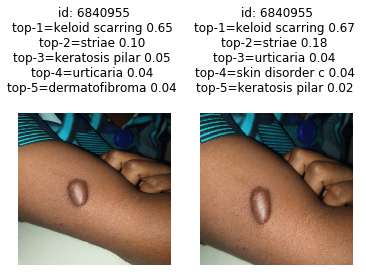

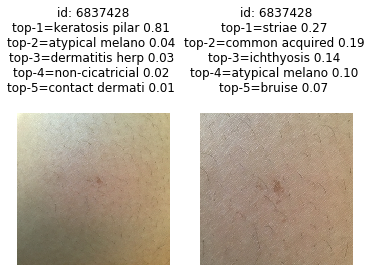

In [24]:
max_k = 5
for img_id in target_ids:
    plt.figure() # Create a new figure. Carefully if do too many times.
    sample = id_to_record[img_id]
    crop = sample['crop']
    img_filename = sample['storage_key']
    img_path = os.path.join(dir_images, img_filename)
    
    
    # For uncropped predictions.
    plt.subplot(1,2,1)
    img = load_preprocess_image(img_path, target_size, crop_coords=None, pre_func=None, pre_args=pre_args)
    plt.imshow(img/255)
    plt.axis('off')
    
    # Convert the multiple predictions from each model into a single set of predictions.
    sorted_preds, probs = preds_from_probs(all_probs_uncrop[img_id])
    title_str = get_title_pred_str(sorted_preds, probs, index_to_diagnosis, max_k)
    plt.title(title_str)
    
    
    # For cropped predictions.
    plt.subplot(1,2,2)
    img = load_preprocess_image(img_path, target_size, crop_coords=crop, pre_func=None, pre_args=pre_args)
    plt.imshow(img/255)
    plt.axis('off')
    
    sorted_preds, probs = preds_from_probs(all_probs_crop[img_id])
    title_str = get_title_pred_str(sorted_preds, probs, index_to_diagnosis, max_k)
    plt.title(title_str)